<a href="https://colab.research.google.com/github/alecd1014/Alec_INFO5731_Spring2025/blob/main/Duray_Alec_Assignment_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INFO5731 Assignment 5**

---


**This exercise aims to provide a comprehensive learning experience in text analysis and machine learning techniques, focusing on both text classification and clustering tasks.**

***Please use the text corpus you collected in your last in-class-exercise for this exercise. Perform the following tasks***.

**Expectations**:
*   Students are expected to complete the exercise during lecture period to meet the active participation criteria of the course.
*   Use the provided .*ipynb* document to write your code & respond to the questions. Avoid generating a new file.
*   Write complete answers and run all the cells before submission.
*   Make sure the submission is "clean"; *i.e.*, no unnecessary code cells.
*   Once finished, allow shared rights from top right corner (*see Canvas for details*).

**Total points**: 100

**Full Points will be given those who present well**

**Late submissions will have a penalty of 10% of the marks for each day of late submission, and no requests will be answered. Manage your time accordingly.**


# **Question 1 (20 Points)**

# **SENTIMENT ANALYSIS**

The objective of this assignment is to give you **hands-on experience** in applying various** sentiment analysis techniques** on real-world textual data. You are expected to explore data, apply machine learning models, and evaluate their performance

**1. Dataset Collection & Preparation**

Find a real-world dataset with text and positive, negative, and neutral sentiment labels.

Justify your dataset choice and handle **class imbalance** if needed.

**2. Exploratory Data Analysis (EDA)**

Clean and preprocess the data (tokenization, stopwords, lemmatization).

Perform EDA: class distribution, word clouds, n-gram analysis, sentence lengths, etc.

Visualize insights using relevant plots and charts.

**3. Sentiment Classification**

Apply at least three traditional ML models (e.g., SVM, Naive Bayes, XGBoost) using TF-IDF or embeddings.

If applicable, compare with a pretrained model (RoBERTa/BERT).

Tune hyperparameters and use cross-validation.

**4. Evaluation & Reporting**

Evaluate with metrics: Accuracy, Precision, Recall, F1, Confusion Matrix.

Summarize results, compare models, and reflect on what worked.

In [2]:
#Part 1
#I chose to use the 1000 reviews dataset as it has numerical reviews for each entry
#so they can easily be placed into their different classes. Each entry also has
#a text review on which sentiment analysis can be performed.

#Part 2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import re
import string

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

df = pd.read_csv('1000reviews.csv')
#stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

#create function for text preprocessing
def preprocess(text):
  text = text.lower()
  text = re.sub(r'\d+', '', text)
  text = text.translate(str.maketrans('', '', string.punctuation))
  tokens = word_tokenize(text)
  tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words and w.isalpha()]
  return tokens

#run the text column in the file through the preprocessing function
#and create new columns in the dataframe for the clean text
df['clean_tokens'] = df['Text'].astype(str).apply(preprocess)
df['clean_text'] = df['clean_tokens'].apply(lambda x: ' '.join(x))
df['text_length'] = df['Text'].astype(str).apply(lambda x: len(x.split()))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


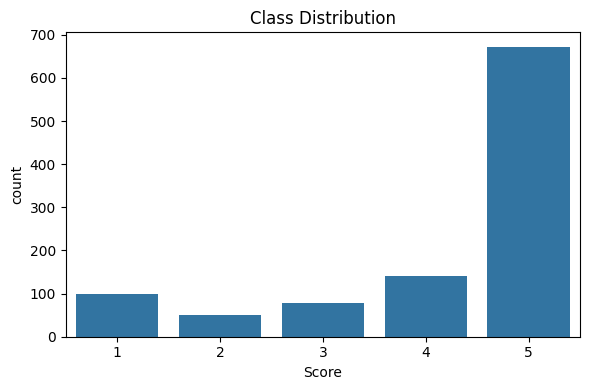

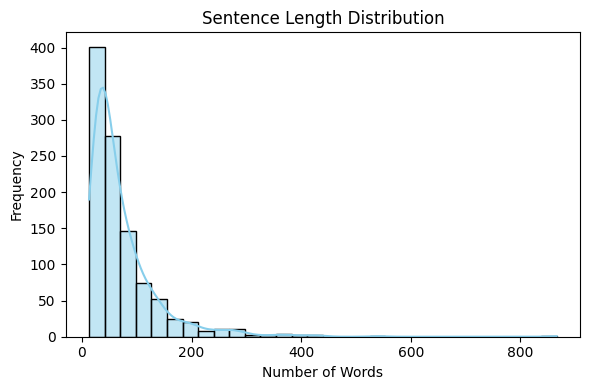

In [3]:
#EDA and visualizations of EDA

#visualization of class distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Score')
plt.title('Class Distribution')
plt.tight_layout()
plt.show()

#visualization of sentence length distribution
plt.figure(figsize=(6,4))
sns.histplot(df['text_length'], bins=30, kde=True, color='skyblue')
plt.title('Sentence Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

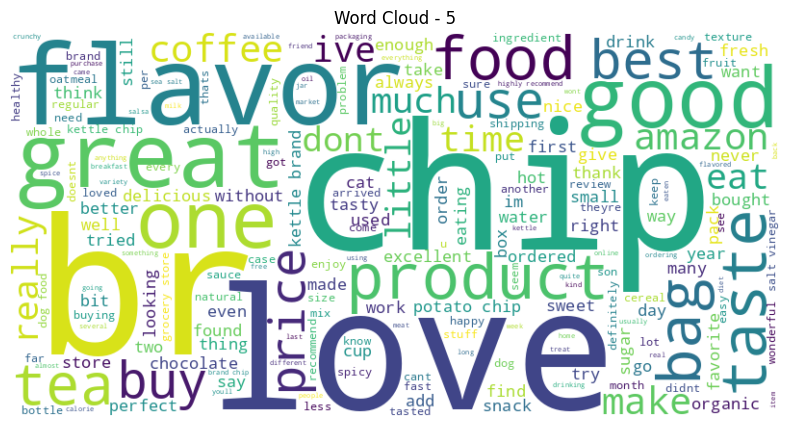

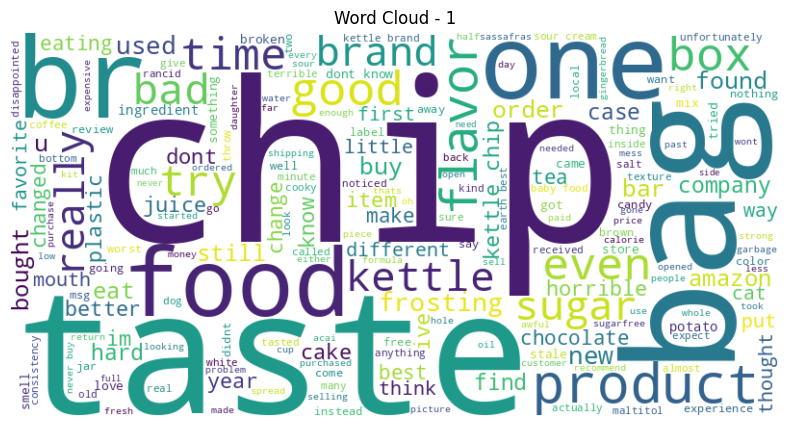

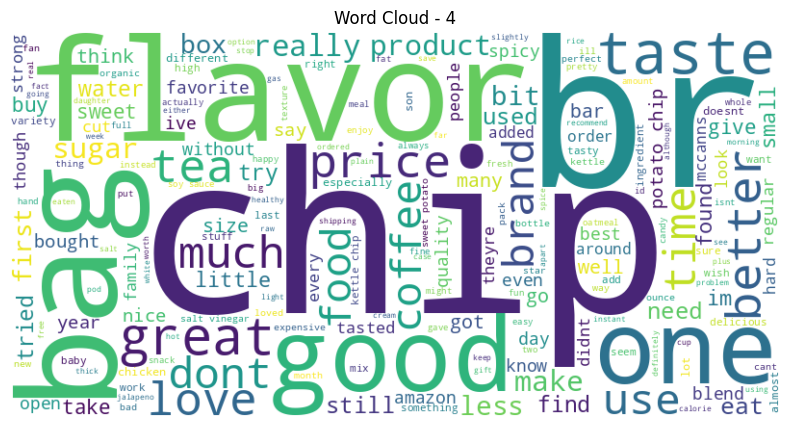

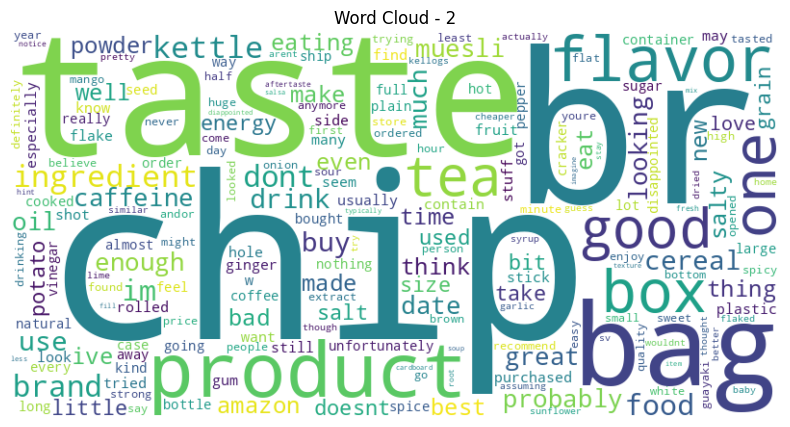

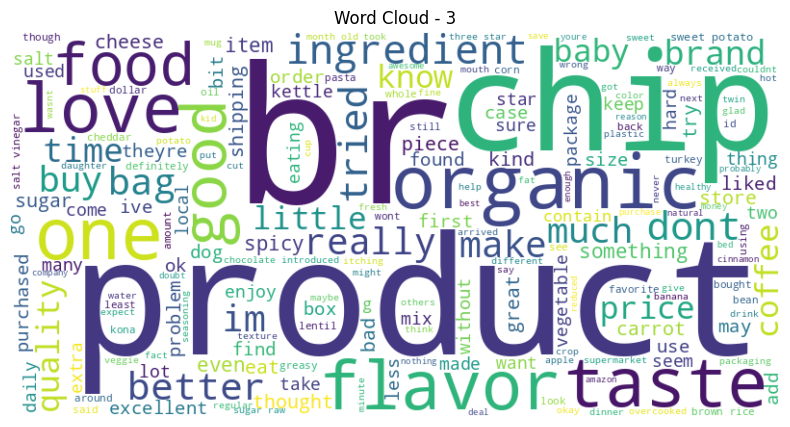

In [4]:
#loop to create word cloud for each score
for score in df['Score'].unique():
  text = " ".join(df[df['Score'] == score]['clean_text'])
  wc = WordCloud(width=800, height=400, background_color='white').generate(text)
  plt.figure(figsize=(10, 5))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis('off')
  plt.title(f"Word Cloud - {score}")
  plt.show()

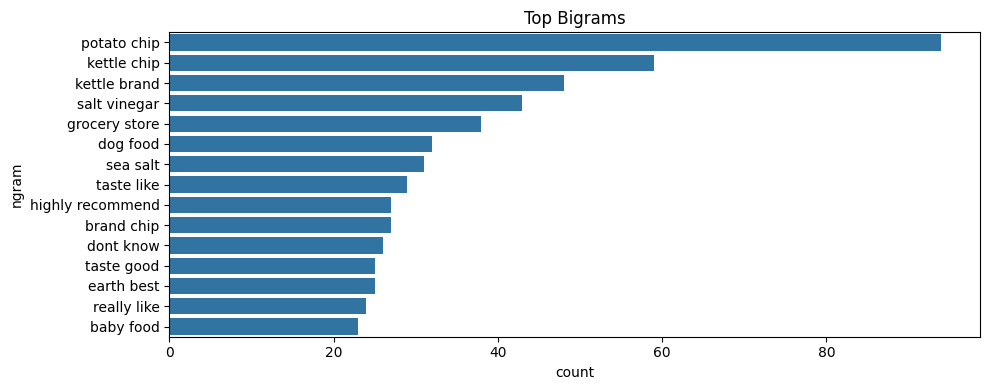

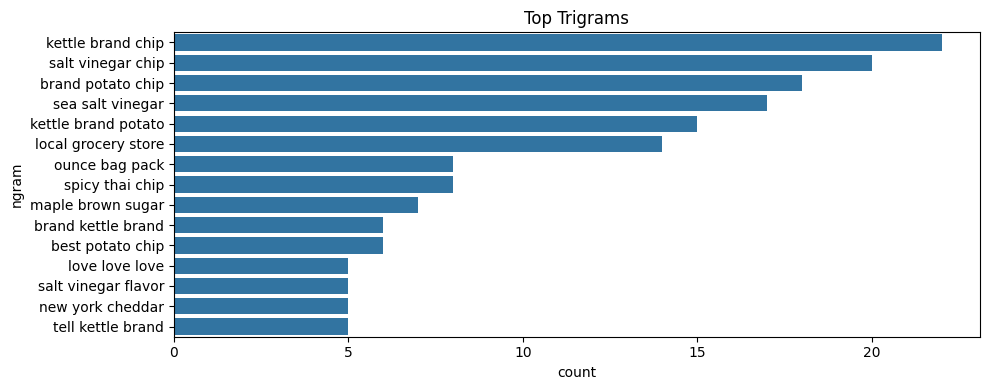

In [5]:
#create function to retrieve the top n-grams in the text of the reviews
def find_top_ngrams(corpus, ngram_range=(1,1), n=None):
  vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
  bag_of_words = vec.transform(corpus)
  sum_words = bag_of_words.sum(axis=0)
  words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
  words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
  return words_freq[:n]

#create a visualization for the top bigrams and trigrams in the reviews
for ngram, title in zip([(2,2), (3,3)], ['Bigrams', 'Trigrams']):
  top_ngrams = find_top_ngrams(df['clean_text'], ngram_range=ngram, n=15)
  ngram_df = pd.DataFrame(top_ngrams, columns=['ngram', 'count'])
  plt.figure(figsize=(10, 4))
  sns.barplot(data=ngram_df, x='count', y='ngram')
  plt.title(f"Top {title}")
  plt.tight_layout()
  plt.show()

In [6]:
#Part 3
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

#get the dataset
df = pd.read_csv('1000reviews.csv')
#write function to clean the text column of the dataset
def preprocess(text):
  text = re.sub(r'<.*?>', '', text) #remove any html
  text = re.sub(r'[^a-zA-Z]', ' ', text) #remove any non-alpha characters
  text = text.lower() #convert to lowercase
  return text

df['clean_text'] = df['Text'].apply(preprocess)

#split the score into different sentiments
def get_sentiment(score):
  if score in [1, 2]:
    return 'Negative'
  elif score == 3:
    return 'Neutral'
  else:
    return 'Positive'
df['Sentiment'] = df['Score'].apply(get_sentiment)

#split dataset into the text and the classes or score
X = df['clean_text']
y = df['Sentiment']
#split the dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#create the TF-IDF vectorization
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

#apply the naive bayes model
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
y_pred_nb = nb.predict(X_test_tfidf)

#apply the SVM model
svm = LinearSVC()
svm.fit(X_train_tfidf, y_train)
y_pred_svm = svm.predict(X_test_tfidf)

#apply the XGBoost model
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train_tfidf, y_train_encoded)
y_pred_xgb = xgb_model.predict(X_test_tfidf)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:16:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [7]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
#tune hyperparameters and perform cross validation for naive bayes model
#define the parameter grid
nb_params = {'alpha': [0.1, 0.5, 1.0]}

#perform the grid search with cross-validation
nb_model = GridSearchCV(MultinomialNB(), nb_params, cv=5, scoring='f1_weighted', n_jobs=-1)
nb_model.fit(X_train_tfidf, y_train)

#get the best estimator and the predictions
nb_best = nb_model.best_estimator_
nb_preds = nb_best.predict(X_test_tfidf)

#tune hyperparameters and perform cross validation for SVM model
#define the parameter grid
svm_params = {'C': [0.01, 0.1, 1, 10]}

#use a grid search with 5-fold cross-validation
svm_model = GridSearchCV(LinearSVC(), svm_params, cv=5, scoring='f1_weighted', n_jobs=-1)
svm_model.fit(X_train_tfidf, y_train)

#get the best estimator and the predictions
svm_best = svm_model.best_estimator_
svm_preds = svm_best.predict(X_test_tfidf)

#tune hyperparameters and perform cross validation for XGBoost model
#define the parameter grid for tuning
xgb_params = {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.3],
              'subsample': [0.7, 1.0]}

# Initialize model and randomized search
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model = RandomizedSearchCV(xgb_clf, xgb_params, n_iter=10, cv=5, scoring='f1_weighted', n_jobs=-1, random_state=42)
xgb_model.fit(X_train_tfidf, y_train_encoded)

# Best estimator and predictions
xgb_best = xgb_model.best_estimator_
xgb_preds = xgb_best.predict(X_test_tfidf)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:19:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Naive Bayes Results:
Accuracy: 0.8173076923076923
Precision: 0.7415019681810726
Recall: 0.8173076923076923
F1 Score: 0.7571988955119214
Confusion Matrix:
 [[  5   0  19]
 [  0   0  17]
 [  2   0 165]]
SVM Results:
Accuracy: 0.8317307692307693
Precision: 0.8352390852390853
Recall: 0.8317307692307693
F1 Score: 0.8075447989510489
Confusion Matrix:
 [[ 11   0  13]
 [  1   3  13]
 [  8   0 159]]
XGBoost Results:
Accuracy: 0.7980769230769231
Precision: 0.7288868538868538
Recall: 0.7980769230769231
F1 Score: 0.7588267070008642
Confusion Matrix:
 [[  8   0  16]
 [  2   0  15]
 [  6   3 158]]


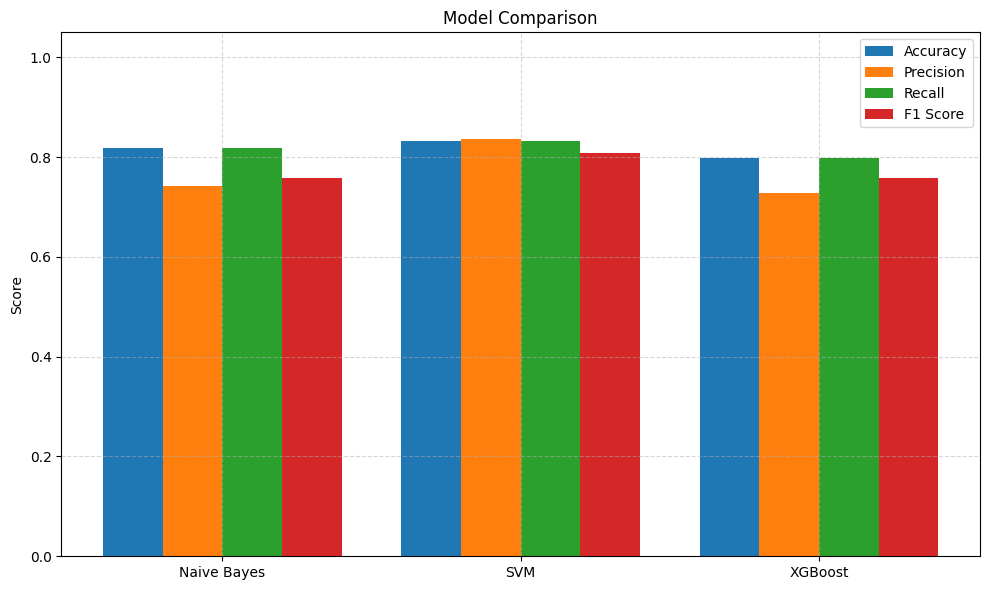

In [9]:
#Part 4
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np

#evaluation metrics for naive bayes model
nb_acc = accuracy_score(y_test, nb_preds)
nb_prec, nb_rec, nb_f1, _ = precision_recall_fscore_support(y_test, nb_preds, average='weighted')
nb_cm = confusion_matrix(y_test, nb_preds, labels=['Negative', 'Neutral', 'Positive'])

print("Naive Bayes Results:")
print("Accuracy:", nb_acc)
print("Precision:", nb_prec)
print("Recall:", nb_rec)
print("F1 Score:", nb_f1)
print("Confusion Matrix:\n", nb_cm)

#evaluation metrics for SVM model
svm_acc = accuracy_score(y_test, svm_preds)
svm_prec, svm_rec, svm_f1, _ = precision_recall_fscore_support(y_test, svm_preds, average='weighted')
svm_cm = confusion_matrix(y_test, svm_preds, labels=['Negative', 'Neutral', 'Positive'])

print("SVM Results:")
print("Accuracy:", svm_acc)
print("Precision:", svm_prec)
print("Recall:", svm_rec)
print("F1 Score:", svm_f1)
print("Confusion Matrix:\n", svm_cm)

#evaluation metrics for XGBoost model
xgb_preds_decoded = label_encoder.inverse_transform(xgb_preds)
xgb_acc = accuracy_score(y_test, xgb_preds_decoded)
xgb_prec, xgb_rec, xgb_f1, _ = precision_recall_fscore_support(y_test, xgb_preds_decoded, average='weighted')
xgb_cm = confusion_matrix(y_test, xgb_preds_decoded, labels=['Negative', 'Neutral', 'Positive'])

print("XGBoost Results:")
print("Accuracy:", xgb_acc)
print("Precision:", xgb_prec)
print("Recall:", xgb_rec)
print("F1 Score:", xgb_f1)
print("Confusion Matrix:\n", xgb_cm)

#create a plot to compare the models
model_names = ['Naive Bayes', 'SVM', 'XGBoost']

accuracies = [nb_acc, svm_acc, xgb_acc]
precisions = [nb_prec, svm_prec, xgb_prec]
recalls = [nb_rec, svm_rec, xgb_rec]
f1_scores = [nb_f1, svm_f1, xgb_f1]

x = np.arange(len(model_names))
width = 0.2

plt.figure(figsize=(10, 6))
plt.bar(x - 1.5*width, accuracies, width, label='Accuracy')
plt.bar(x - 0.5*width, precisions, width, label='Precision')
plt.bar(x + 0.5*width, recalls, width, label='Recall')
plt.bar(x + 1.5*width, f1_scores, width, label='F1 Score')

plt.xticks(x, model_names)
plt.ylabel('Score')
plt.ylim(0, 1.05)
plt.title('Model Comparison')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## **Question 2 (30 Points)**

# **Text Classification**

The purpose of the question is to practice different machine learning algorithms for **text classification** as well as the performance evaluation. In addition, you are requried to conduct **10 fold cross validation** (https://scikit-learn.org/stable/modules/cross_validation.html) in the training.



The dataset can be download from canvas. The dataset contains two files train data and test data for sentiment analysis in IMDB review, it has two categories: 1 represents positive and 0 represents negative. You need to split the training data into training and validate data (80% for training and 20% for validation, https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6) and perform 10 fold cross validation while training the classifier. The final trained model was final evaluated on the test data.



1.   **Perform EDA on test and tran dataset**

2.   **Algorithms (Minimum 4):**

*   SVM
*   KNN
*   Decision tree
*   Random Forest
*   XGBoost
*   Word2Vec
*   BERT

3. **Evaluation measurement:**

*   Accuracy
*   Recall
*   Precison
*   F-1 score


In [10]:
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, precision_score, f1_score

#load the data from the files and create a dataframe using that data
def load_data(filepath):
  with open(filepath, 'r', encoding='utf-8') as f:
    lines = f.readlines()
  labels, texts = zip(*[(int(line[0]), line[2:].strip()) for line in lines if len(line.strip()) > 1])
  return pd.DataFrame({'text': texts, 'label': labels})

train_df = load_data('stsa-train.txt')
test_df = load_data('stsa-test.txt')

#split train data into 80% training and 20% validation
train_split, val_split = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=42)

#list which models are going to be used
models = {'SVM': SVC(), 'KNN': KNeighborsClassifier(), 'Decision Tree': DecisionTreeClassifier(),
          'Random Forest': RandomForestClassifier()}

#create a common pipeline with TF-IDF
def build_pipeline(model):
  return Pipeline([('tfidf', TfidfVectorizer()), ('clf', model)])

#train and evaluate each model with 10 fold cross-validation
for name, model in models.items():
  pipeline = build_pipeline(model)
  print(f"\nTraining {name}...")
  scores = cross_validate(pipeline, train_split['text'], train_split['label'], cv=10,
                          scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'],
                          return_train_score=False)
  for metric in scores:
    print(f"{metric}: {scores[metric].mean():.4f}")

  #fit each model on the full training split and evaluate on the test set
  pipeline.fit(train_split['text'], train_split['label'])
  preds = pipeline.predict(test_df['text'])

  acc = accuracy_score(test_df['label'], preds)
  prec = precision_score(test_df['label'], preds, average='macro')
  rec = recall_score(test_df['label'], preds, average='macro')
  f1 = f1_score(test_df['label'], preds, average='macro')
  #print the results for each model
  print(f"Test set results for {name}:")
  print(f"Accuracy:  {acc:.4f}")
  print(f"Precision: {prec:.4f}")
  print(f"Recall:    {rec:.4f}")
  print(f"F1 Score:  {f1:.4f}")


Training SVM...
fit_time: 5.6388
score_time: 0.4558
test_accuracy: 0.7858
test_precision_macro: 0.7862
test_recall_macro: 0.7843
test_f1_macro: 0.7848
Test set results for SVM:
Accuracy:  0.8029
Precision: 0.8042
Recall:    0.8029
F1 Score:  0.8027

Training KNN...
fit_time: 0.1123
score_time: 0.1602
test_accuracy: 0.7234
test_precision_macro: 0.7236
test_recall_macro: 0.7222
test_f1_macro: 0.7223
Test set results for KNN:
Accuracy:  0.7260
Precision: 0.7275
Recall:    0.7260
F1 Score:  0.7255

Training Decision Tree...
fit_time: 1.4792
score_time: 0.0223
test_accuracy: 0.6080
test_precision_macro: 0.6073
test_recall_macro: 0.6071
test_f1_macro: 0.6070
Test set results for Decision Tree:
Accuracy:  0.5755
Precision: 0.5763
Recall:    0.5756
F1 Score:  0.5745

Training Random Forest...
fit_time: 6.7499
score_time: 0.0743
test_accuracy: 0.7188
test_precision_macro: 0.7194
test_recall_macro: 0.7166
test_f1_macro: 0.7169
Test set results for Random Forest:
Accuracy:  0.7199
Precision: 0.7

## **Question 3 (30 Points)**

# **Text Clustering**

The purpose of the question is to practice different machine learning algorithms for **text clustering**.

Please downlad the dataset by using the following link.  https://www.kaggle.com/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones
(You can also use different text data which you want)


1.   Perform EDA on selected dataset

2.   **Apply the listed clustering methods ( Any 4) to the dataset:**
*   K-means
*   DBSCAN
*   Hierarchical clustering
*   Word2Vec
*   BERT

3. **Visualize the clusters**

You can refer to of the codes from  the follwing link below.
https://www.kaggle.com/karthik3890/text-clustering

In [11]:
#start with EDA on the dataset
df = pd.read_csv('Amazon_Unlocked_Mobile.csv')
#I decided to sample 1000 items to make it easier on my computer
#drop the rows with missing reviews and then sample 1000 items
sample_df = df[df['Reviews'].notnull()].sample(n=1000, random_state=42).reset_index(drop=True)

#summary statistics and review length
sample_df['review_length'] = sample_df['Reviews'].apply(lambda x: len(x.split()))

eda_summary = {'missing_values': sample_df.isnull().sum(),
               'rating_distribution': sample_df['Rating'].value_counts().sort_index(),
               'review_length_stats': sample_df['review_length'].describe()}
eda_summary

{'missing_values': Product Name       0
 Brand Name       152
 Price             16
 Rating             0
 Reviews            0
 Review Votes      26
 review_length      0
 dtype: int64,
 'rating_distribution': Rating
 1    173
 2     76
 3     77
 4    162
 5    512
 Name: count, dtype: int64,
 'review_length_stats': count    1000.000000
 mean       41.053000
 std        80.299852
 min         1.000000
 25%         5.000000
 50%        17.000000
 75%        43.000000
 max      1062.000000
 Name: review_length, dtype: float64}

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


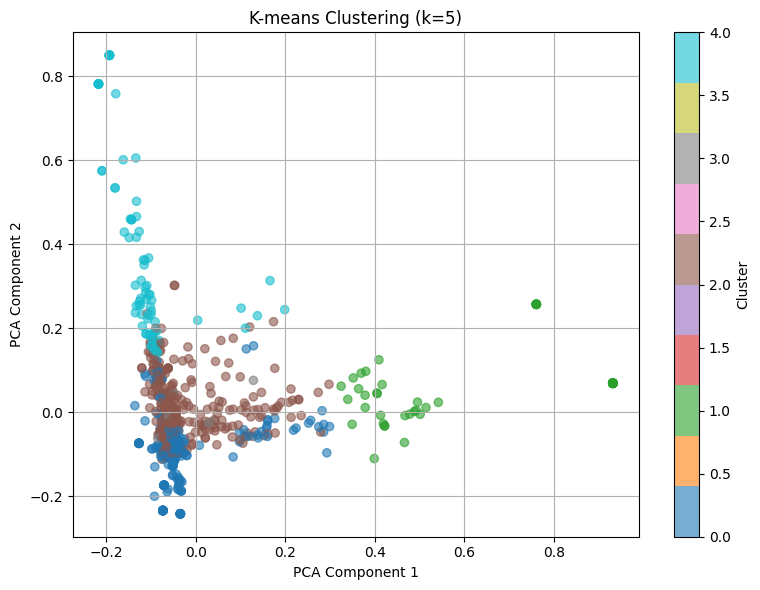

In [12]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
#define the preprocessing function
def preprocess(text):
  text = text.lower()
  text = re.sub(r'[^a-z\s]', '', text)
  tokens = text.split()
  tokens = [word for word in tokens if word not in stop_words]
  return ' '.join(tokens)

#apply the preprocessing
sample_df['cleaned_review'] = sample_df['Reviews'].apply(preprocess)

#vectorize using TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = vectorizer.fit_transform(sample_df['cleaned_review'])

#apply K-means clustering and visualize the cluster
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(X_tfidf)

#reduce the dimensions for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_tfidf.toarray())

#plot the clusters
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='tab10', alpha=0.6)
plt.title("K-means Clustering (k=5)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

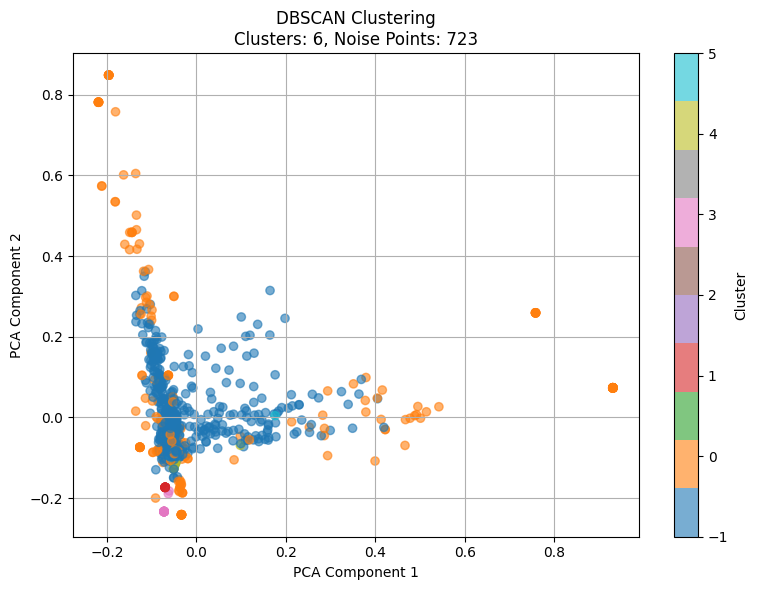

In [34]:
#apply DBSCAN clustering and visualize the clusters
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=5, metric='cosine')
dbscan_labels = dbscan.fit_predict(X_tfidf)

#define the number of clusters and the noise points
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise_dbscan = list(dbscan_labels).count(-1)

#visualization with PCA
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='tab10', alpha=0.6)
plt.title(f"DBSCAN Clustering\nClusters: {n_clusters_dbscan}, Noise Points: {n_noise_dbscan}")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

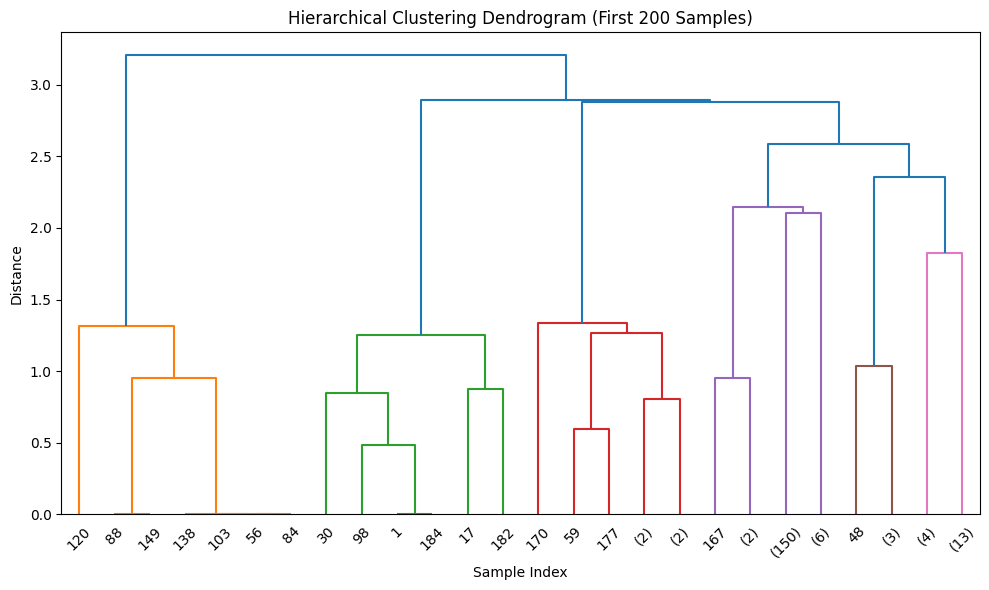

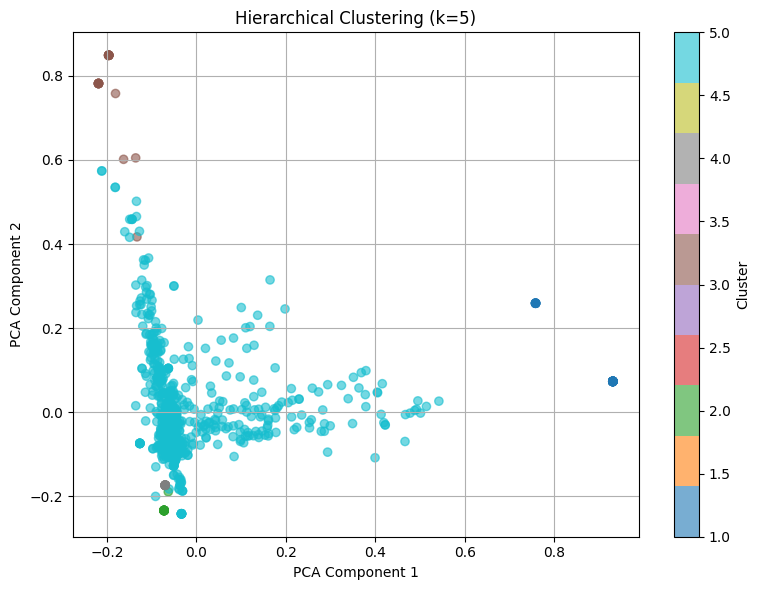

In [35]:
#apply hierarchical clustering and visualize the clusters
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

#I used a smaller sample for the dendrogram visualization to reduce the clutter
X_small = X_tfidf[:200].toarray()

#perform the hierarchical clustering
linkage_matrix = linkage(X_small, method='ward')

#plot the dendrogram
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix, truncate_mode='level', p=5)
plt.title("Hierarchical Clustering Dendrogram (First 200 Samples)")
plt.xlabel("Sample Index") #I would use the names instead of the indexes, put I found that it was too hard to read
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

#apply flat clustering from the full dataset
X_array = X_tfidf.toarray()
hier_labels = fcluster(linkage(X_array, method='ward'), t=5, criterion='maxclust')

#use PCA for the visualization
X_pca_hier = PCA(n_components=2, random_state=42).fit_transform(X_array)

#plot the clusters
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca_hier[:, 0], X_pca_hier[:, 1], c=hier_labels, cmap='tab10', alpha=0.6)
plt.title("Hierarchical Clustering (k=5)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

In [44]:
!pip install --upgrade gensim

In [40]:
!pip install --upgrade numpy

  Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.5 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.5 which is incompatible.


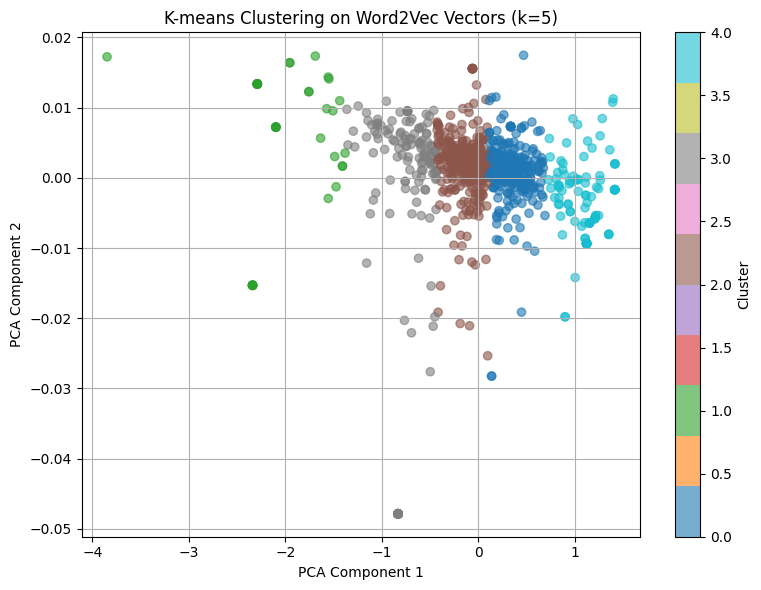

In [13]:
#apply Word2Vec clustering and visualize the clusters
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from sklearn.cluster import KMeans

#tokenize the reviews for Word2Vec
tokenized_reviews = sample_df['cleaned_review'].apply(simple_preprocess).tolist()

#train the Word2Vec model
w2v_model = Word2Vec(sentences=tokenized_reviews, vector_size=100, window=5, min_count=2, workers=4, seed=42)

#create a function to get the average Word2Vec vector for a document
def average_word_vector(tokens, model, vector_size):
  vectors = [model.wv[word] for word in tokens if word in model.wv]
  if vectors:
    return np.mean(vectors, axis=0)
  else:
    return np.zeros(vector_size)

#create the document vectors
doc_vectors = np.array([average_word_vector(tokens, w2v_model, 100) for tokens in tokenized_reviews])

#perform K-means clustering on the Word2Vec vectors
kmeans_w2v = KMeans(n_clusters=5, random_state=42)
w2v_labels = kmeans_w2v.fit_predict(doc_vectors)

#use PCA for the visualization
pca_w2v = PCA(n_components=2, random_state=42)
X_pca_w2v = pca_w2v.fit_transform(doc_vectors)

#plot the clusters
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca_w2v[:, 0], X_pca_w2v[:, 1], c=w2v_labels, cmap='tab10', alpha=0.6)
plt.title("K-means Clustering on Word2Vec Vectors (k=5)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

**In one paragraph, please compare the results of K-means, DBSCAN, Hierarchical clustering, Word2Vec, and BERT.**

**Write your response here:**

.The results of K-means, DBSCAN, and Hierarchical clustering seemed to be very
similar to each other. The only method of clustering which I tested that
produced different results was the Word2Vec. I suspect that this might be
because Word2Vec is very similar to K-means, but with tokens being used.

.

.

.

.




# Mandatory Question

**Important: Reflective Feedback on this exercise**

Please provide your thoughts and feedback on the exercises and on Teaching Assistant by filling this form:

https://docs.google.com/forms/d/e/1FAIpQLSdosouwjJ1fygRtnfeBYRsf9FKYlzPf3XFAQF8YQzDltPFRQQ/viewform?usp=dialog

**(Your submission will not be graded if this question is left unanswered)**

